In [ ]:
!pip install segmentation-models-pytorch
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split as tts
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet

# Metrics
from segmentation_models_pytorch.metrics import get_stats, iou_score

# os
import os

# Path
from pathlib import Path

# tqdm

from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

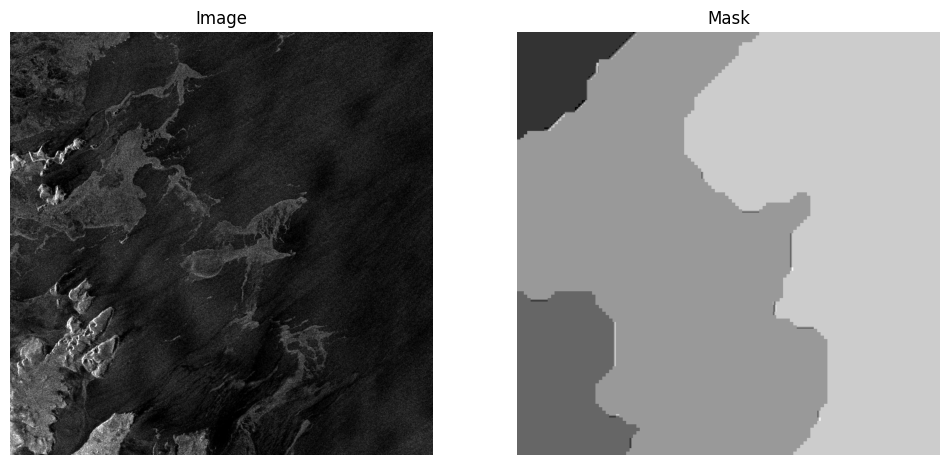

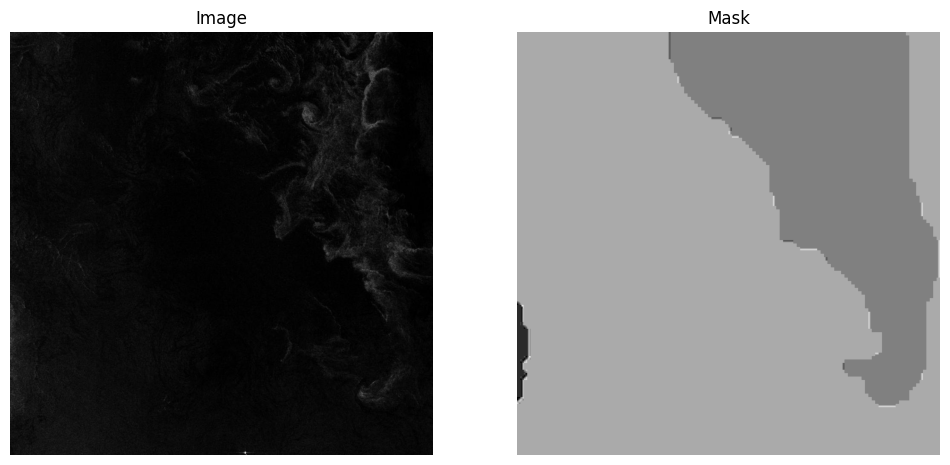

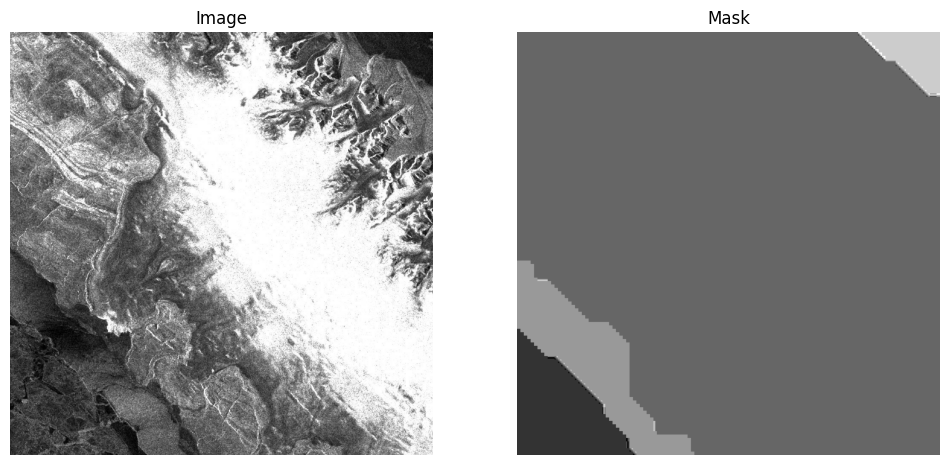

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Путь к папке с масками и изображениями
dataset_folder = "/content/drive/MyDrive/crop_dataset_fixed/"
images_folder = os.path.join(dataset_folder, "cropped_images")
masks_folder = os.path.join(dataset_folder, "cropped_masks")

# Получаем список файлов изображений
image_files = os.listdir(images_folder)

# Выбираем три случайных изображения
random_images = random.sample(image_files, 3)

# Показываем каждую пару изображение-маска
for image_file in random_images:
    # Путь к изображению
    image_path = os.path.join(images_folder, image_file)

    # Прочитаем изображение с помощью OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Переводим цветовую схему для корректного отображения в matplotlib

    # предполагается, что маска имеет тот же формат, что и изображение
    mask_path = os.path.join(masks_folder, image_file)

    # Прочитаем маску с помощью OpenCV
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Выведем изображение и маску
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Изображение
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Маска
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()


In [ ]:
import os
import random
import shutil

dataset_folder = "/content/drive/MyDrive/crop_dataset_fixed/"
train_folder = "train_data"
val_folder = "val_data"
test_folder = "test_data"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(train_folder+"/masks", exist_ok=True)
os.makedirs(train_folder+"/images", exist_ok=True)

os.makedirs(val_folder, exist_ok=True)
os.makedirs(val_folder+"/masks", exist_ok=True)
os.makedirs(val_folder+"/images", exist_ok=True)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(test_folder+"/masks", exist_ok=True)
os.makedirs(test_folder+"/images", exist_ok=True)

image_files = os.listdir(images_folder)

random.shuffle(image_files)

train_size = int(0.7 * len(image_files))
val_size = int(0.15 * len(image_files))
test_size = len(image_files) - train_size - val_size

train_images = image_files[:train_size]
val_images = image_files[train_size:train_size+val_size]
test_images = image_files[train_size+val_size:]


for image_file in train_images:
    fixed_name = image_file.replace(".jpg","").replace(".","") +".jpg"
    shutil.copy(os.path.join(images_folder, image_file), os.path.join(train_folder+"/images", fixed_name))
    shutil.copy(os.path.join(masks_folder, image_file), os.path.join(train_folder+"/masks", fixed_name.replace(".jpg", "_mask.jpg")))

for image_file in val_images:
    fixed_name = image_file.replace(".jpg","").replace(".","") +".jpg"
    shutil.copy(os.path.join(images_folder, image_file), os.path.join(val_folder+"/images", fixed_name))
    shutil.copy(os.path.join(masks_folder, image_file), os.path.join(val_folder+"/masks", fixed_name.replace(".jpg", "_mask.jpg")))

for image_file in test_images:
    fixed_name = image_file.replace(".jpg","").replace(".","") +".jpg"
    shutil.copy(os.path.join(images_folder, image_file), os.path.join(test_folder+"/images", fixed_name))
    shutil.copy(os.path.join(masks_folder, image_file), os.path.join(test_folder+"/masks", fixed_name.replace(".jpg", "_mask.jpg")))

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet

# Metrics
from segmentation_models_pytorch.metrics import get_stats, iou_score

In [ ]:
SEED = 123

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset as BaseDataset
from torchvision.transforms.functional import resize

RESIZE_SIZE=448

class CustomDataset(Dataset):
    def __init__(self, root_dir, image_transforms:transforms, mask_transforms:transforms):
        self.root_dir = root_dir
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = os.listdir(self.image_folder)
        self.mask_files = os.listdir(self.mask_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        image = image.Resize((RESIZE_SIZE,RESIZE_SIZE))
        image = self.image_transforms(image)


        mask_name = os.path.join(self.mask_folder, self.mask_files[idx])
        mask = Image.open(mask_name).convert("L")  # Преобразование в черно-белый режим
        mask = mask.Resize((RESIZE_SIZE,RESIZE_SIZE))
        mask = self.mask_transforms(mask)

        for x in range(RESIZE_SIZE):
          for y in range(RESIZE_SIZE):
            if(mask[x,y]>4):
              mask[x,y] = 0
            else:
              mask[x,y]-=1


        return image, mask

class NewCustomDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['high-concentration', 'ground',  'low-concentration',"water"]

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        print(self.ids)
        print(os.listdir(masks_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = Image.open(self.images_fps[i]).convert("RGB")
        image = image.resize((RESIZE_SIZE,RESIZE_SIZE))
        image = np.array(image)

        mask = Image.open(self.masks_fps[i].replace(".jpg", "_mask.jpg")).convert("L")  # Преобразование в черно-белый режим
        mask = mask.resize((RESIZE_SIZE,RESIZE_SIZE))
        mask = np.array(mask)

        for x in range(RESIZE_SIZE):
          for y in range(RESIZE_SIZE):
            if(mask[x,y]>4):
              mask[x,y] = 0
            else:
              mask[x,y]-=1

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [ ]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

['S1A_EW_GRDM_1SDH_20211229T032220_20211229T032324_041218_04E601_C6DB_RGB_pngrf1261b220d1cde3813d45325c5a6c5a34_3720_1488.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_5952_2976.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_4464_2976.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_5208_5208.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_5952_5952.jpg', 'S1A_EW_GRDM_1SDH_20231219T032535_20231219T032635_051718_063EFF_E803_RGB_pngrf662798027a7b7af62196204cd26d4cbe_4464_7440.jpg', 'S1A_EW_GRDM_1SDH_20231014T041154_20231014T041258_050756_061DCE_A663_RGB_pngrfc7b8da14a39ea4d8696d7d3e3443826f_4464_2976.jpg', 'S1A_EW_GRDM_1SDH_20220729T035520_20220729T035624_044310_0549C7_A8B6_RGB_pngrf35d31b160e726b17635a9135b7e6cb43

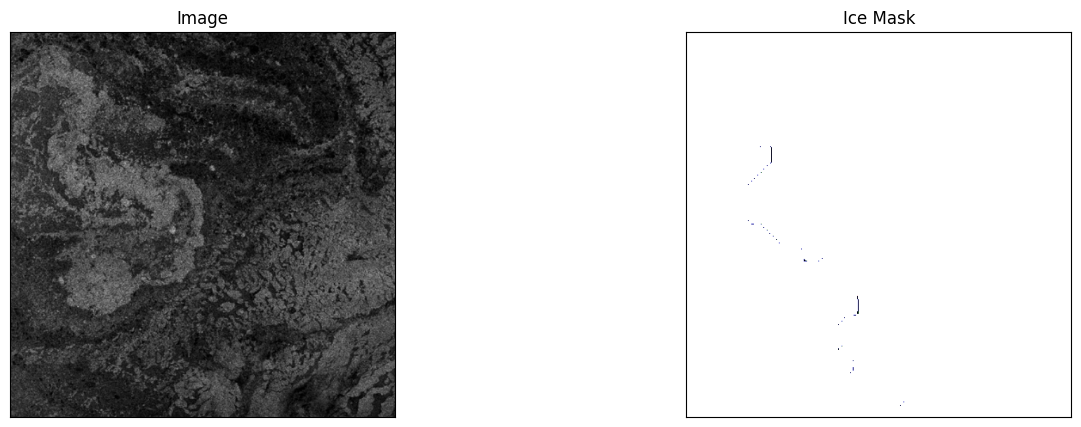

In [ ]:
x_train_dir = "train_data/images/"
y_train_dir = "train_data/masks/"

x_val_dir = "train_data/images/"
y_val_dir = "train_data/masks/"

CLASSES = ['high-concentration', 'ground',  'low-concentration',"water"]

dataset = NewCustomDataset(x_train_dir, y_train_dir, classes=['high-concentration', 'ground',  'low-concentration',"water"])

image, mask = dataset[10] # get some sample
print(mask.shape)
visualize(
    image=image,
    ice_mask=mask.squeeze(),
)

In [ ]:
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms as transforms
from tqdm import tqdm

# Определение функции потерь
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES =  ['high-concentration', 'ground',  'low-concentration',"water"]
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# Определение архитектуры U-Net
model = Unet(    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,)



preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:01<00:00, 224MB/s]


In [ ]:
x_train_dir = "train_data/images/"
y_train_dir = "train_data/masks/"

x_val_dir = "val_data/images/"
y_val_dir = "val_data/masks/"

CLASSES = ['high-concentration', 'ground',  'low-concentration',"water"]

train_dataset = NewCustomDataset(
    x_train_dir,
    y_train_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

val_dataset = NewCustomDataset(
    x_val_dir,
    y_val_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

['S1A_EW_GRDM_1SDH_20211229T032220_20211229T032324_041218_04E601_C6DB_RGB_pngrf1261b220d1cde3813d45325c5a6c5a34_3720_1488.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_5952_2976.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_4464_2976.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_5208_5208.jpg', 'S1A_EW_GRDM_1SDH_20240123T024224_20240123T024324_052228_065059_3DC1_RGB_pngrfd39489b8a091c35a734dc49da6e8f4ad_5952_5952.jpg', 'S1A_EW_GRDM_1SDH_20231219T032535_20231219T032635_051718_063EFF_E803_RGB_pngrf662798027a7b7af62196204cd26d4cbe_4464_7440.jpg', 'S1A_EW_GRDM_1SDH_20231014T041154_20231014T041258_050756_061DCE_A663_RGB_pngrfc7b8da14a39ea4d8696d7d3e3443826f_4464_2976.jpg', 'S1A_EW_GRDM_1SDH_20220729T035520_20220729T035624_044310_0549C7_A8B6_RGB_pngrf35d31b160e726b17635a9135b7e6cb43

In [ ]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#for param in model.encoder.parameters():
#    param.requires_grad = False

In [ ]:
#summary(model = model,
#       input_size = [8, 3, 896, 896],
 #       col_width = 15,
 #       col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
 #      row_settings = ['var_names'])

In [ ]:
import segmentation_models_pytorch.utils

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

In [ ]:
import gc
max_score = 0

for i in range(0, 5):
    gc.collect()
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 5/5 [00:31<00:00,  6.35s/it, dice_loss - 0.4166, iou_score - 0.5051]
Model saved!

Epoch: 1
valid: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it, dice_loss - 0.3537, iou_score - 0.5804]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:33<00:00,  6.68s/it, dice_loss - 0.3392, iou_score - 0.6085]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:34<00:00,  6.85s/it, dice_loss - 0.299, iou_score - 0.6295]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:31<00:00,  6.29s/it, dice_loss - 0.2997, iou_score - 0.6134]


In [ ]:
best_model = torch.load('./best_model.pth')

In [ ]:
x_test_dir = "test_data/images/"
y_test_dir = "test_data/masks/"

test_dataset = NewCustomDataset(
    x_test_dir,
    y_test_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

['S1A_EW_GRDM_1SDH_20220527T033140_20220527T033240_043391_052E7F_3C17_RGB_pngrf261ae43907049faed8f2326ae64e3029_3720_4464.jpg', 'S1A_EW_GRDM_1SDH_20231014T041154_20231014T041258_050756_061DCE_A663_RGB_pngrfc7b8da14a39ea4d8696d7d3e3443826f_5208_3720.jpg', 'S1A_EW_GRDM_1SDH_20220525T034805_20220525T034905_043362_052D97_9249_RGB_pngrfedcd95830264ffaedffa20b95f0f31b3_744_3720.jpg', 'S1A_EW_GRDM_1SDH_20231219T032535_20231219T032635_051718_063EFF_E803_RGB_pngrf662798027a7b7af62196204cd26d4cbe_4464_6696.jpg', 'S1A_EW_GRDM_1SDH_20231219T032535_20231219T032635_051718_063EFF_E803_RGB_pngrf662798027a7b7af62196204cd26d4cbe_3720_5208.jpg', 'S1A_EW_GRDM_1SDH_20231014T041154_20231014T041258_050756_061DCE_A663_RGB_pngrfc7b8da14a39ea4d8696d7d3e3443826f_2232_2232.jpg', 'S1A_EW_GRDM_1SDH_20220525T034805_20220525T034905_043362_052D97_9249_RGB_pngrfedcd95830264ffaedffa20b95f0f31b3_1488_2976.jpg', 'S1A_EW_GRDM_1SDH_20220729T035520_20220729T035624_044310_0549C7_A8B6_RGB_pngrf35d31b160e726b17635a9135b7e6cb43_

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=device,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 37/37 [00:36<00:00,  1.01it/s, dice_loss - 0.3281, iou_score - 0.6291]


In [ ]:
logs

{'dice_loss': 0.3281291562157708, 'iou_score': 0.6290854450969678}

In [ ]:
test_dataset_vis = NewCustomDataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

['S1A_EW_GRDM_1SDH_20220527T033140_20220527T033240_043391_052E7F_3C17_RGB_pngrf261ae43907049faed8f2326ae64e3029_3720_4464.jpg', 'S1A_EW_GRDM_1SDH_20231014T041154_20231014T041258_050756_061DCE_A663_RGB_pngrfc7b8da14a39ea4d8696d7d3e3443826f_5208_3720.jpg', 'S1A_EW_GRDM_1SDH_20220525T034805_20220525T034905_043362_052D97_9249_RGB_pngrfedcd95830264ffaedffa20b95f0f31b3_744_3720.jpg', 'S1A_EW_GRDM_1SDH_20231219T032535_20231219T032635_051718_063EFF_E803_RGB_pngrf662798027a7b7af62196204cd26d4cbe_4464_6696.jpg', 'S1A_EW_GRDM_1SDH_20231219T032535_20231219T032635_051718_063EFF_E803_RGB_pngrf662798027a7b7af62196204cd26d4cbe_3720_5208.jpg', 'S1A_EW_GRDM_1SDH_20231014T041154_20231014T041258_050756_061DCE_A663_RGB_pngrfc7b8da14a39ea4d8696d7d3e3443826f_2232_2232.jpg', 'S1A_EW_GRDM_1SDH_20220525T034805_20220525T034905_043362_052D97_9249_RGB_pngrfedcd95830264ffaedffa20b95f0f31b3_1488_2976.jpg', 'S1A_EW_GRDM_1SDH_20220729T035520_20220729T035624_044310_0549C7_A8B6_RGB_pngrf35d31b160e726b17635a9135b7e6cb43_

[[[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 ...

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]]


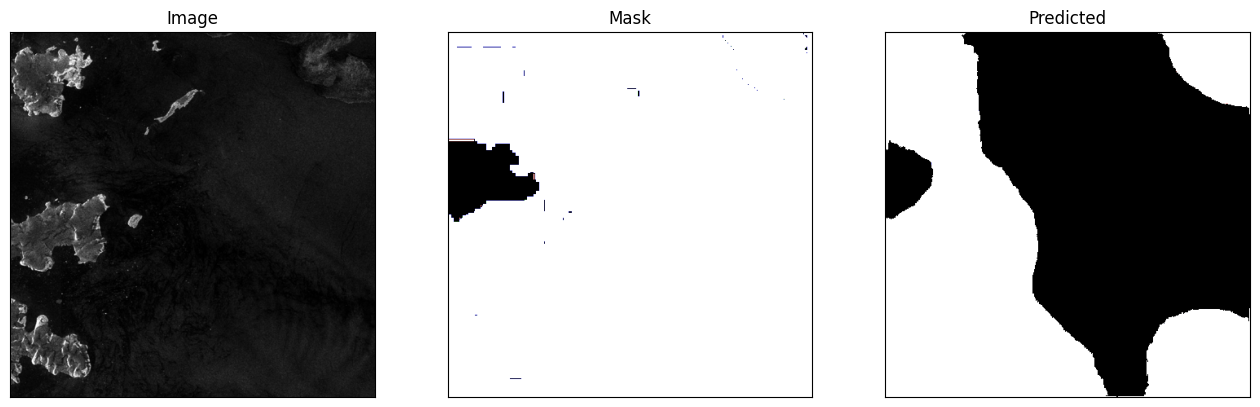

[[[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 ...

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]]


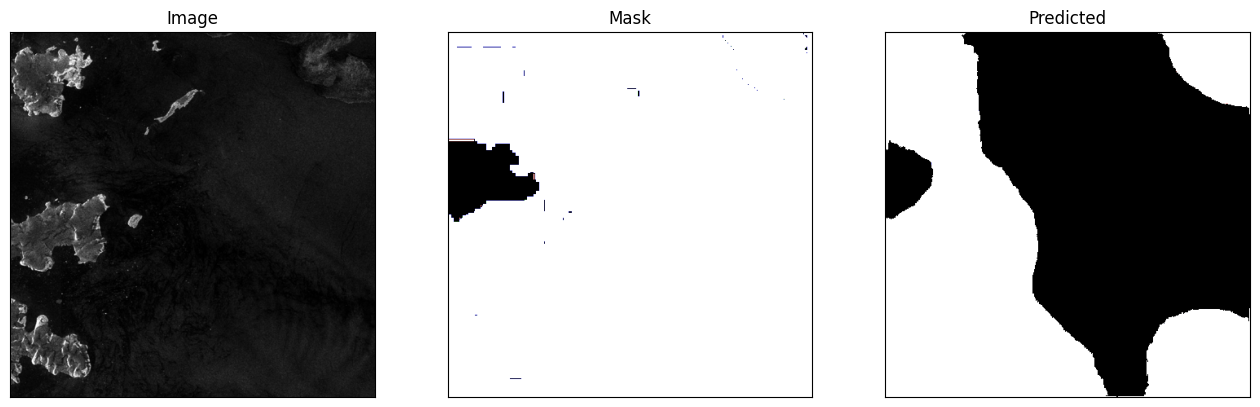

[[[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 ...

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]]


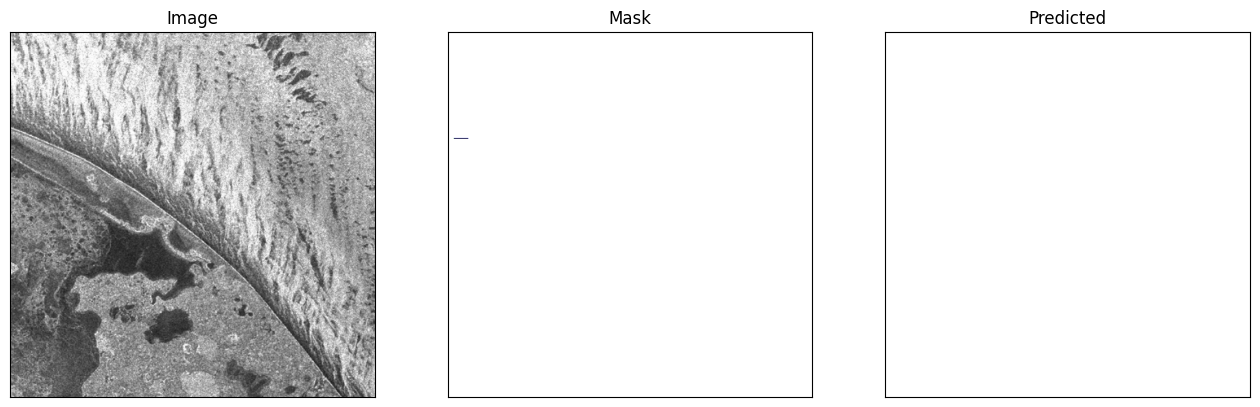

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 ...

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]]


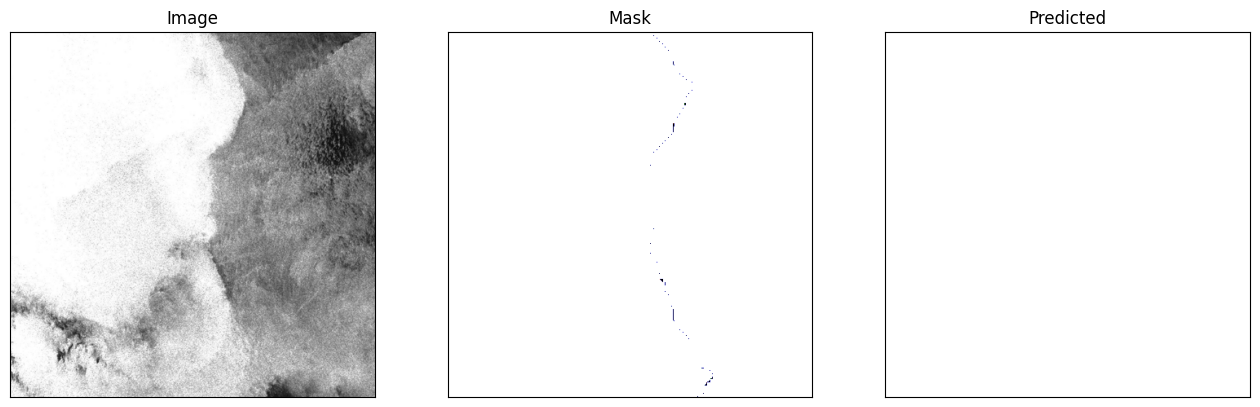

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 ...

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]]


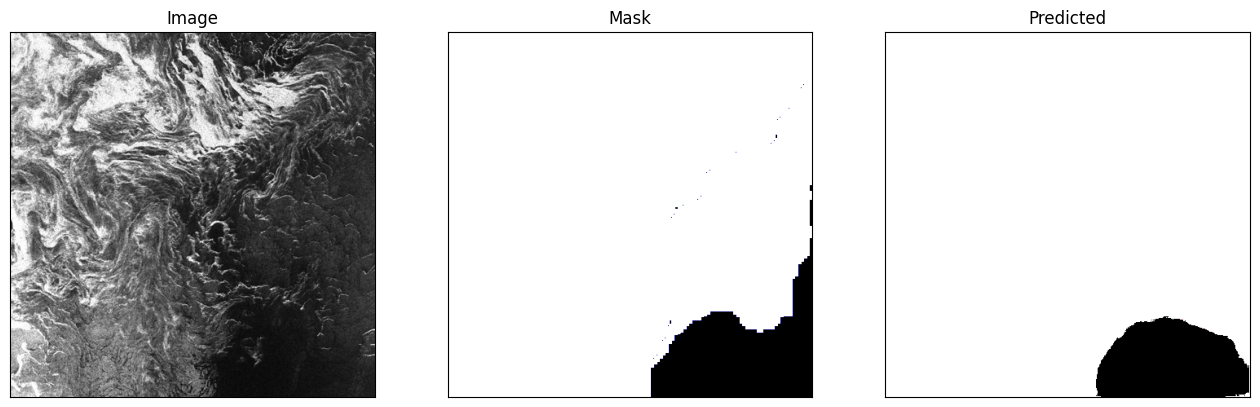

[[[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 ...

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]]


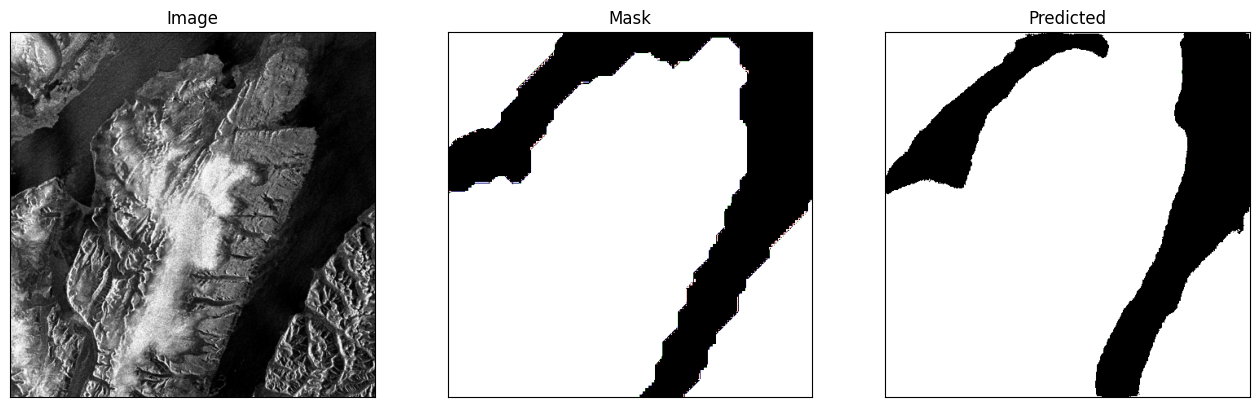

[[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 ...

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]]


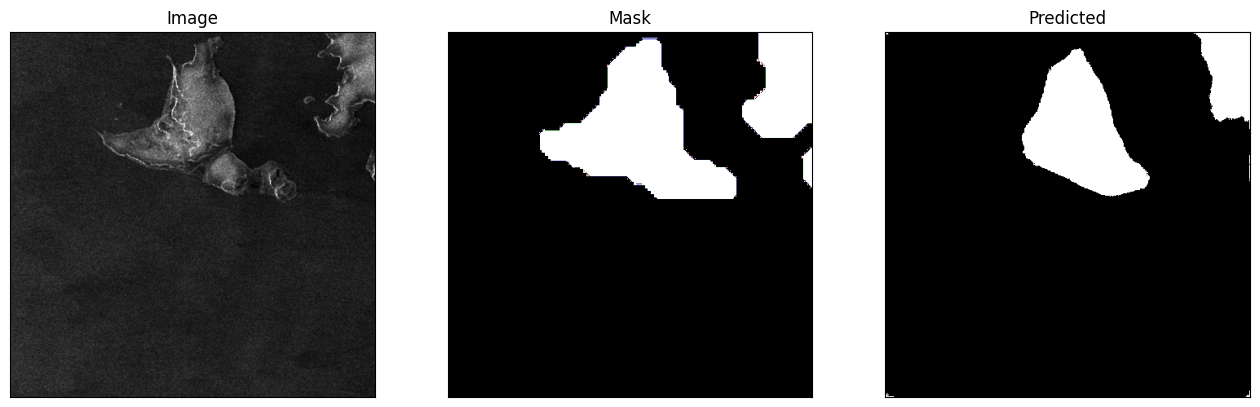

[[[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 ...

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]]


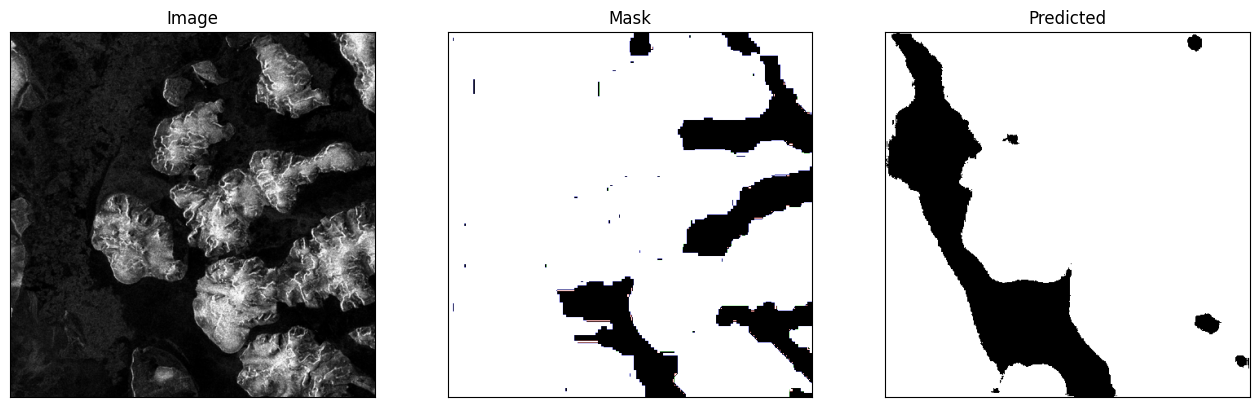

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 ...

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]]


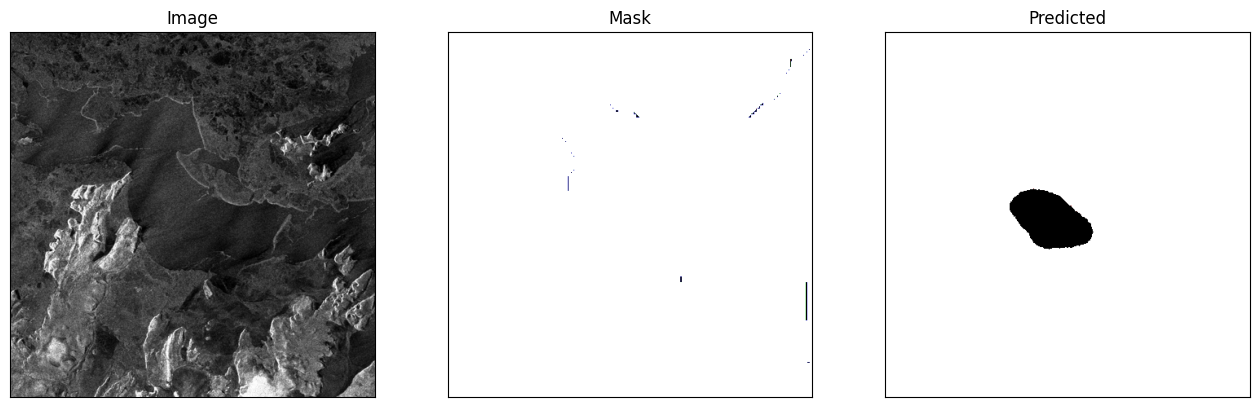

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 ...

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]]


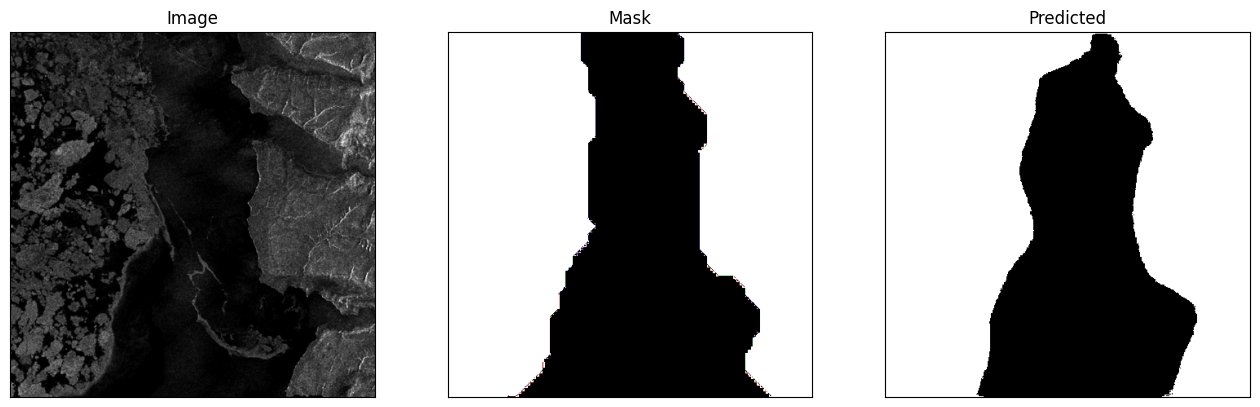

In [ ]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze().transpose(1, 2, 0)

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).transpose(1, 2, 0)

    print(gt_mask)
    visualize(
        image=image_vis,
        mask=gt_mask,
        predicted = pr_mask
    )

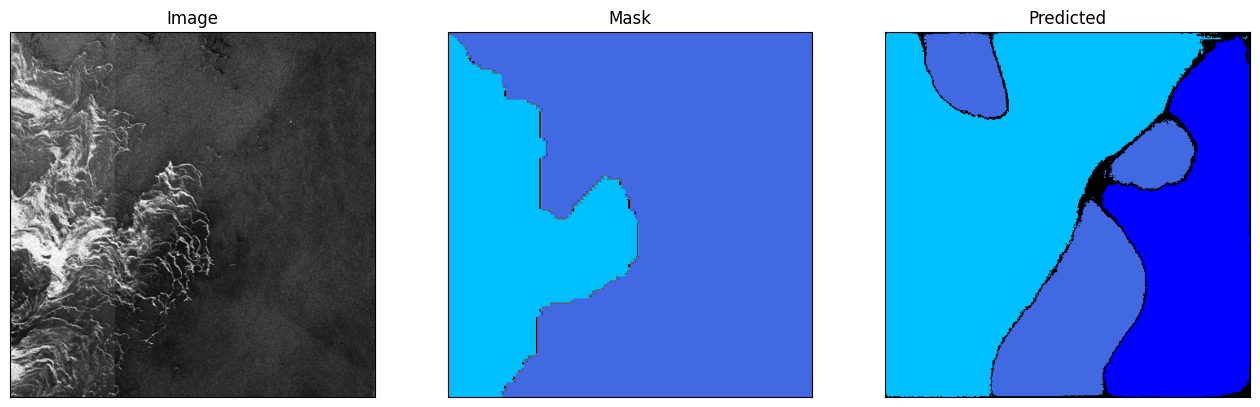

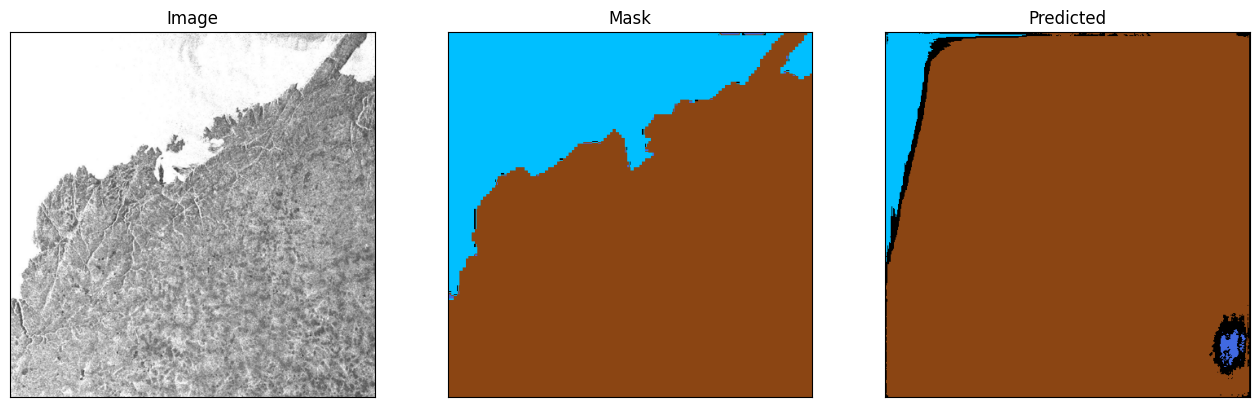

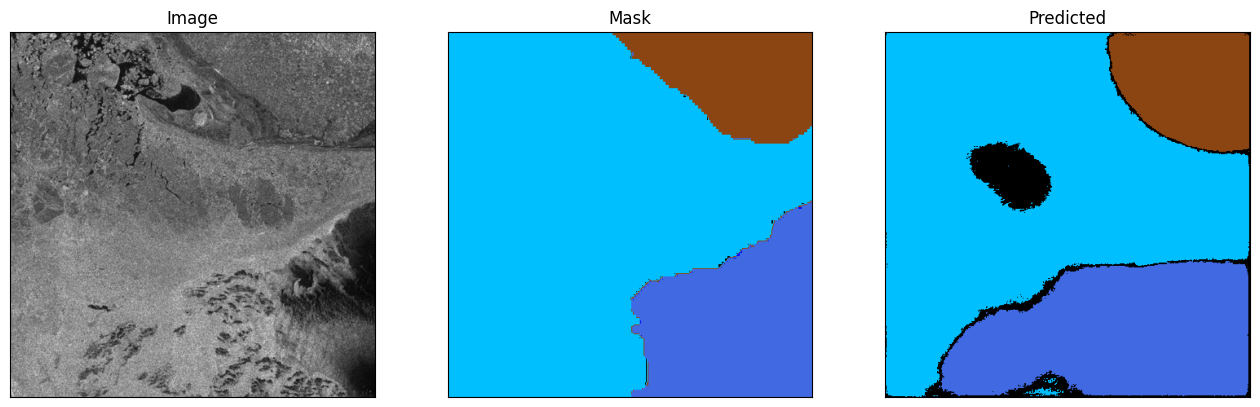

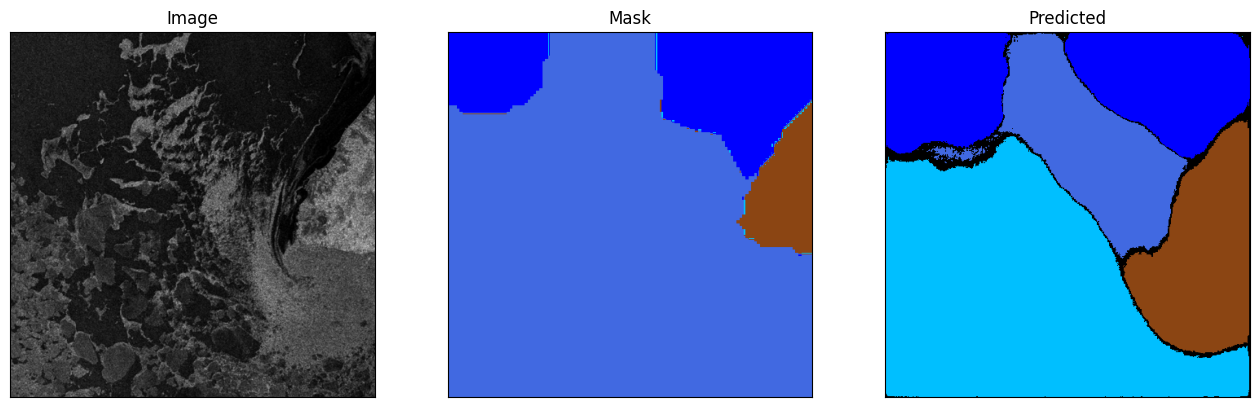

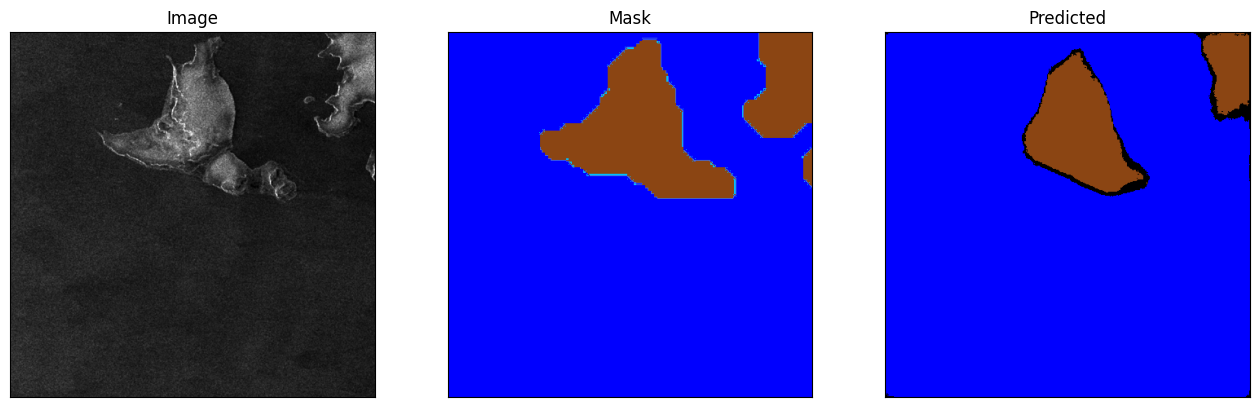

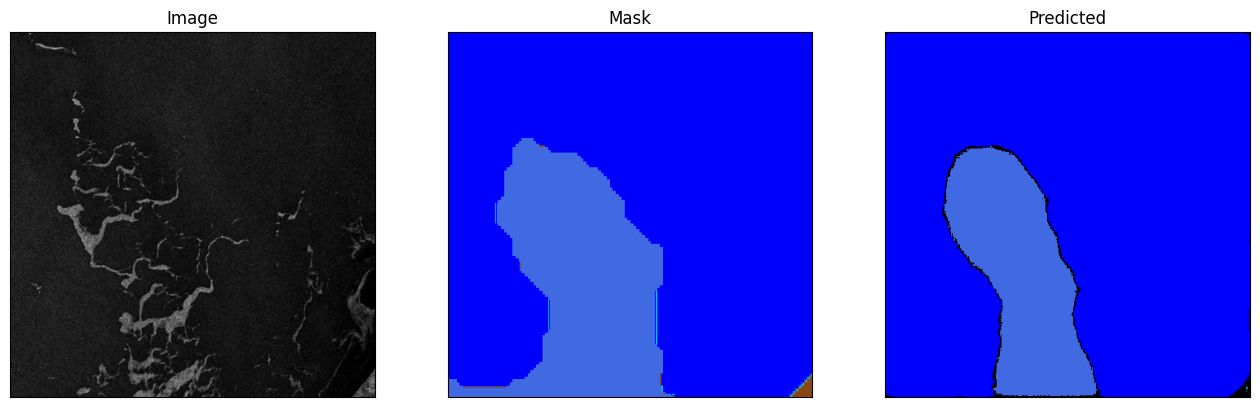

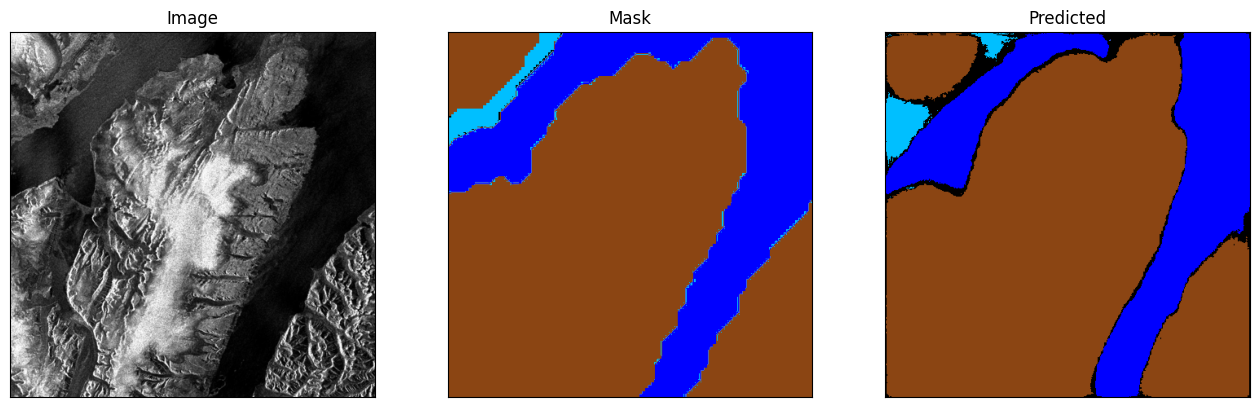

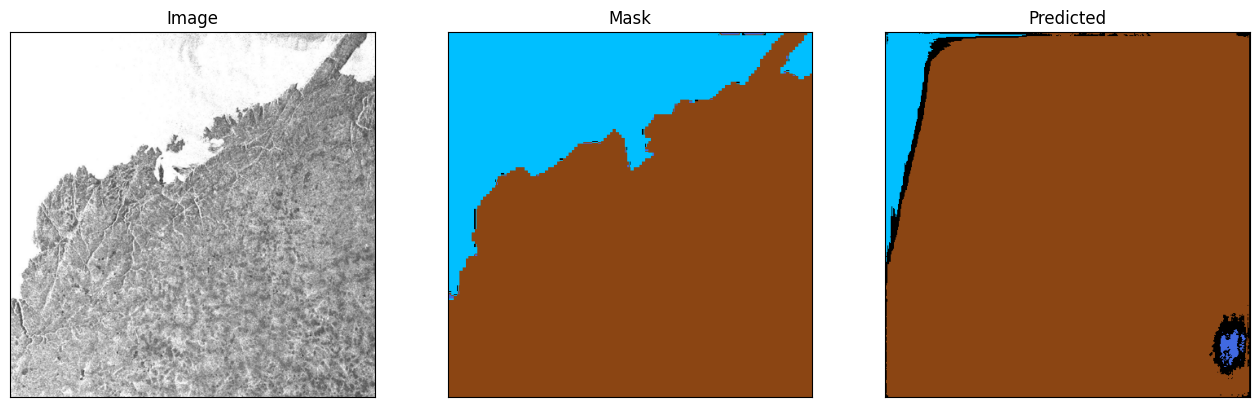

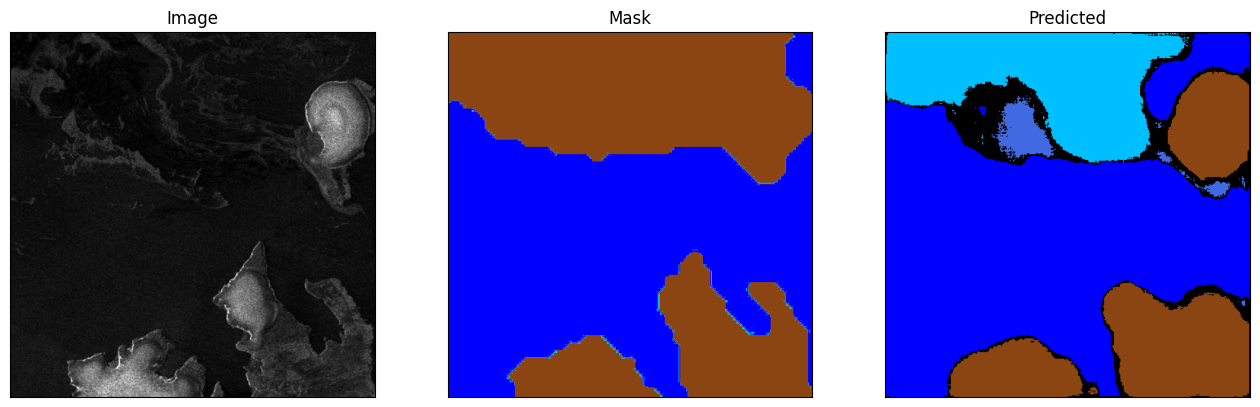

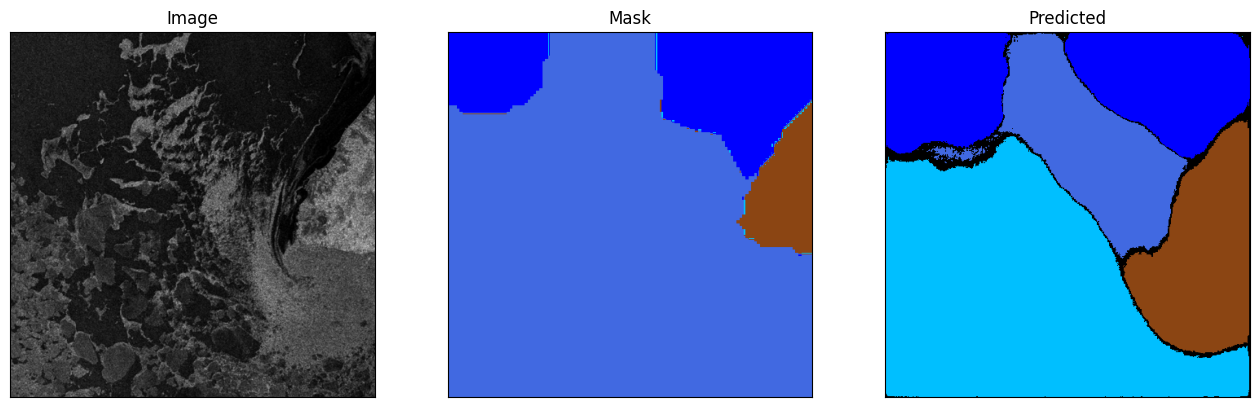

In [ ]:
def mask_to_image(mask, color_palette):
    img = np.zeros((RESIZE_SIZE, RESIZE_SIZE, 3), dtype=np.uint8)

    for i in range(RESIZE_SIZE):
      for j in range(RESIZE_SIZE):
        found = False
        for q in range(4):
          if(mask[i,j,q]==1):
            img[i,j] = color_palette[q]
            found = True
            break

        if(not found):
          img[i,j] = color_palette[4]

    return img

color_palette = [
    [0, 191, 255],  # Класс 0 - Голубой (высокая сплоченность льда)
    [139, 69, 19],    # Класс 1 - Коричневый (земля)
    [65, 105, 225],  # Класс 2 - Светло-голубой (низкая сплоченность льда)
    [0, 0, 255],       # Класс 3 - Синий (вода)
    [0,0,0] #Класс 4 - НЕИЗВЕСТНО
]

for i in range(10):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze().transpose(1, 2, 0)


    target_mask_image = mask_to_image(gt_mask, color_palette)

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).transpose(1, 2, 0)

    predicted_mask_image = mask_to_image(pr_mask, color_palette)

    visualize(
        image=image_vis,
        mask=target_mask_image,
        predicted = predicted_mask_image
    )